### Training a Convolutional Net in `PyTorch`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
import torch
import torchvision

In [3]:
import torchvision.transforms as transforms

Use built in transformers to prepare images. 

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [5]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                       download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, 
                                         shuffle = True, num_workers = 2)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
testset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                      download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
          'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

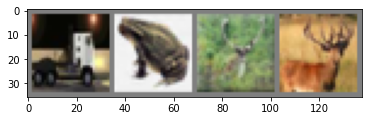

truck  frog  deer  deer


In [10]:
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### Define Convolutional Neural Network

In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
net = Net()

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [15]:
for epoch in range(2):
    
    running_loss = 0.0
    for i,data in enumerate(trainloader, 0):
        inputs,labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'{epoch + 1}, {i + 1}, {running_loss/2000}')
            running_loss = 0.0
            
print('finished running')

1, 2000, 2.20165730714798
1, 4000, 1.8831806644499303
1, 6000, 1.6550756857693196
1, 8000, 1.5779227012246848
1, 10000, 1.4973090054243803
1, 12000, 1.4778930072188377
finished running
2, 2000, 1.3922632906734944
2, 4000, 1.3702714075371623
2, 6000, 1.3464068487435579
2, 8000, 1.3289018322452903
2, 10000, 1.309002904355526
2, 12000, 1.2864916206374764
finished running


In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

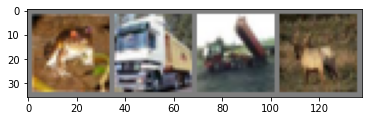

GroundTruth:   frog truck truck  deer


In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
outputs = net(images)

In [20]:
_, predicted = torch.max(outputs, 1)

In [21]:
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    dog truck truck  frog


In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 68 %
Accuracy of  bird : 38 %
Accuracy of   cat : 29 %
Accuracy of  deer : 36 %
Accuracy of   dog : 68 %
Accuracy of  frog : 74 %
Accuracy of horse : 44 %
Accuracy of  ship : 76 %
Accuracy of truck : 57 %
